In [1]:
import sccellfie
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import glasbey

import json

import anndata as ad

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import mpl_fontkit as fk
fk.install("Lato")
fk.set_font("Lato")

Font name: `Lato`


In [4]:
sc.settings.figdir = './GAM-Figures/'

In [7]:
results_dir = './MT-2025-02-18/'

## Load data

In [5]:
saveprefix = 'Epithelial_Gland'

In [6]:
adata = sc.read_h5ad('/nfs/team292/eg22/Datasets/Endometrium/endometriumAtlasV2_cells_with_counts.h5ad', backed='r')

In [8]:
adata.obs['Endometrial_pathology'].unique()

['C', 'E', 'E + F', 'E + A', 'E + A + F']
Categories (5, object): ['C', 'E', 'E + A', 'E + A + F', 'E + F']

In [9]:
adata.obs['Endometriosis'] = adata.obs['Endometrial_pathology'].apply(lambda x: 'Endometriosis' if x != 'C' else 'Control')
adata.obs['E_celltype'] = adata.obs['Endometriosis'].astype(str) + ' - ' + adata.obs['label_long'].astype(str)

In [10]:
cells_to_load = adata.obs[adata.obs['lineage'] == 'Epithelial'].celltype.unique().tolist()

In [11]:
with open(f'{results_dir}/cell_type_mapping.json', mode='r') as fp:
    cell_dict = json.load(fp)

In [13]:
for i, ct in enumerate(cells_to_load):
    mt_df = pd.read_csv('{}/MT_dataframe_{}.csv'.format(results_dir, cell_dict[ct]), index_col=0)
    if i == 0:
        mt_adata = sc.AnnData(X=mt_df, obs=adata[mt_df.index].obs)
    else:
        mt_adata = ad.concat([mt_adata, sc.AnnData(X=mt_df, obs=adata[mt_df.index].obs)], join='outer')

In [14]:
mt_adata.X[np.isnan(mt_adata.X)] = 0

In [15]:
mt_adata.uns['celltype_colors'] = adata.uns['celltype_colors']

In [16]:
cells_to_load

['preGlandular',
 'eHormones',
 'Ciliated',
 'SOX9_functionalis_II',
 'Cycling',
 'preLuminal',
 'SOX9_basalis',
 'SOX9_luminal',
 'Glandular',
 'MUC5B',
 'preCiliated',
 'Luminal',
 'SOX9_functionalis_I',
 'Glandular_secretory',
 'Glandular_secretory_FGF7',
 'KRT5']

In [17]:
cells = ['SOX9_basalis', 'SOX9_functionalis_I', 'SOX9_functionalis_II', 'preGlandular', 'Glandular', 'Glandular_secretory']
# 'Glandular_secretory_FGF7' # Out since is only in a donor

In [18]:
def filter_donors(adata, only_control = True):
    df = adata.obs
    cond_filter = (df.Stage.isin(['Proliferative', 'Proliferative Disordered', 'Proliferative Late']) & \
                   df.celltype.isin(['SOX9_functionalis_I', 'SOX9_functionalis_II']) 
                  ) | \
                  (df.Stage.isin(['Secretory Early', 'Secretory Early-Mid', 'Secretory Mid', 'Secretory Late',]) & \
                   df.celltype.isin(['preGlandular', 'Glandular', 'Glandular_secretory',]) 
                  ) | \
                  (df.Stage.isin(['Proliferative', 'Proliferative Disordered', 'Proliferative Late', 
                                  'Secretory Early', 'Secretory Early-Mid', 'Secretory Mid', 'Secretory Late',]) & \
                   df.celltype.isin(['SOX9_basalis', ]) 
                  )
    if only_control:
        cond_filter = cond_filter & (df.Endometrial_pathology == 'C')
    return adata[cond_filter]

In [19]:
adata = filter_donors(adata)
adata.shape

(27820, 17736)

In [20]:
mt_adata_og = mt_adata.copy()
mt_adata_og.shape

(90563, 215)

In [21]:
mt_adata = filter_donors(mt_adata_og)
mt_adata.shape

(27820, 215)

In [22]:
ct_dict = mt_adata.obs[['celltype', 'label_long']].reset_index(drop=True).drop_duplicates().set_index('celltype')['label_long'].to_dict()
cells = [ct_dict[c] for c in cells]

## Run GAMs to find patterns

In [ ]:
gam_results = sccellfie.stats.fit_gam_model(
    mt_adata,
    cell_type_key='label_long',
    cell_type_order=cells,
    genes=None,
    n_splines=10,
    spline_order=3,
    lam=0.6,
    fit_intercept=True,
    distribution='normal',
    link='identity',
    use_pseudobulk=False,
    pseudobulk_agg='trimean',
    n_pseudobulks=10,
    cells_per_bulk=100,
)

Fitting GAMs for each var in adata: 100%|██████████| 215/215 [00:37<00:00,  5.67it/s]


In [24]:
# Analyze results
results_df = sccellfie.stats.analyze_gam_results(gam_results, fdr_level=0.01)

In [25]:
results_df.head(5)

,n_samples,edof,scale,AIC,loglikelihood,deviance,p_value,explained_deviance,mcfadden_r2,mcfadden_r2_adj,gene,significant,adj_p_value,significant_fdr
Serine degradation,27820.0,5.943863,0.021786,1.114938e+06,-557461.873297,27814.056137,1.110223e-16,0.728214,0.245812,0.754185,Serine degradation,True,1.125934e-16,True
Glycine degradation,27820.0,5.943863,0.028403,8.322727e+05,-416129.397250,27814.056137,1.110223e-16,0.722323,0.246255,0.753742,Glycine degradation,True,1.125934e-16,True
GMP salvage from guanine,27820.0,5.943863,0.304806,7.629048e+04,-38138.296013,27814.056137,1.110223e-16,0.702206,0.261714,0.738245,GMP salvage from guanine,True,1.125934e-16,True
IMP salvage from hypoxanthine,27820.0,5.943863,0.304806,7.629048e+04,-38138.296013,27814.056137,1.110223e-16,0.702206,0.261714,0.738245,IMP salvage from hypoxanthine,True,1.125934e-16,True
Phenylalanine to phenylacetaldehyde,27820.0,5.943863,1.592133,9.449005e+04,-47238.082040,27814.056137,1.110223e-16,0.678418,0.719377,0.280533,Phenylalanine to phenylacetaldehyde,True,1.125934e-16,True


In [26]:
results_df.loc[results_df.significant_fdr]

,n_samples,edof,scale,AIC,loglikelihood,deviance,p_value,explained_deviance,mcfadden_r2,mcfadden_r2_adj,gene,significant,adj_p_value,significant_fdr
Serine degradation,27820.0,5.943863,0.021786,1.114938e+06,-5.574619e+05,27814.056137,1.110223e-16,0.728214,0.245812,0.754185,Serine degradation,True,1.125934e-16,True
Glycine degradation,27820.0,5.943863,0.028403,8.322727e+05,-4.161294e+05,27814.056137,1.110223e-16,0.722323,0.246255,0.753742,Glycine degradation,True,1.125934e-16,True
GMP salvage from guanine,27820.0,5.943863,0.304806,7.629048e+04,-3.813830e+04,27814.056137,1.110223e-16,0.702206,0.261714,0.738245,GMP salvage from guanine,True,1.125934e-16,True
IMP salvage from hypoxanthine,27820.0,5.943863,0.304806,7.629048e+04,-3.813830e+04,27814.056137,1.110223e-16,0.702206,0.261714,0.738245,IMP salvage from hypoxanthine,True,1.125934e-16,True
Phenylalanine to phenylacetaldehyde,27820.0,5.943863,1.592133,9.449005e+04,-4.723808e+04,27814.056137,1.110223e-16,0.678418,0.719377,0.280533,Phenylalanine to phenylacetaldehyde,True,1.125934e-16,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Conversion of asparate to asparagine,27820.0,5.943863,0.024095,9.982013e+05,-4.990937e+05,27814.056137,1.110223e-16,0.004292,0.995040,0.004949,Conversion of asparate to asparagine,True,1.125934e-16,True
Synthesis of serotonin from tryptophan,27820.0,5.943863,0.004008,6.684383e+06,-3.342185e+06,27814.056137,1.110223e-16,0.004090,0.995754,0.004245,Synthesis of serotonin from tryptophan,True,1.125934e-16,True
Tyrosine to dopamine,27820.0,5.943863,0.002423,1.119291e+07,-5.596448e+06,27814.056137,1.110223e-16,0.003233,0.996686,0.003313,Tyrosine to dopamine,True,1.125934e-16,True
Synthesis of taurine from cysteine,27820.0,5.943863,0.004815,5.530237e+06,-2.765112e+06,27814.056137,4.302812e-04,0.000754,0.999212,0.000786,Synthesis of taurine from cysteine,True,4.343214e-04,True


<Axes: >

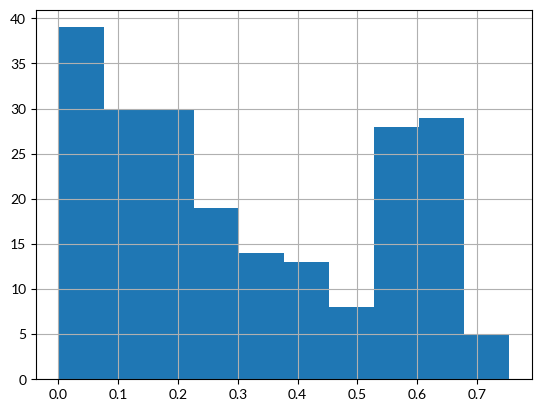

In [27]:
results_df['mcfadden_r2_adj'].hist()

<Axes: >

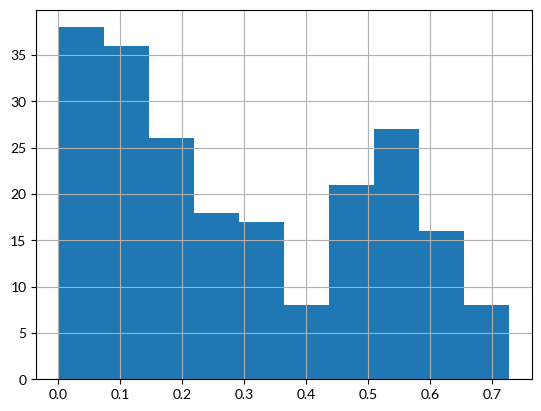

In [28]:
results_df['explained_deviance'].hist()

<Axes: >

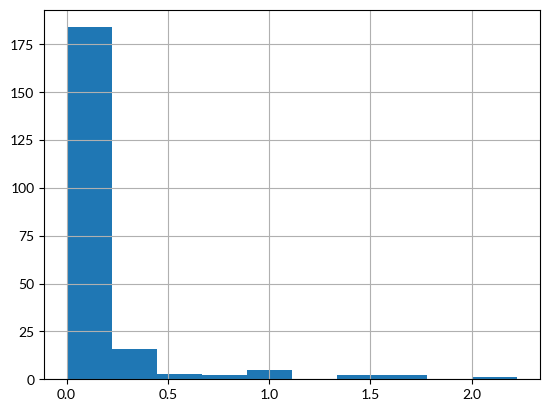

In [29]:
results_df['scale'].hist()

In [30]:
gam_tasks = results_df.loc[(results_df['mcfadden_r2_adj'] > 0.2) & (results_df['scale'] > 0.2)].sort_values(by='scale', ascending=False)['gene'].values.tolist()
len(gam_tasks)

14

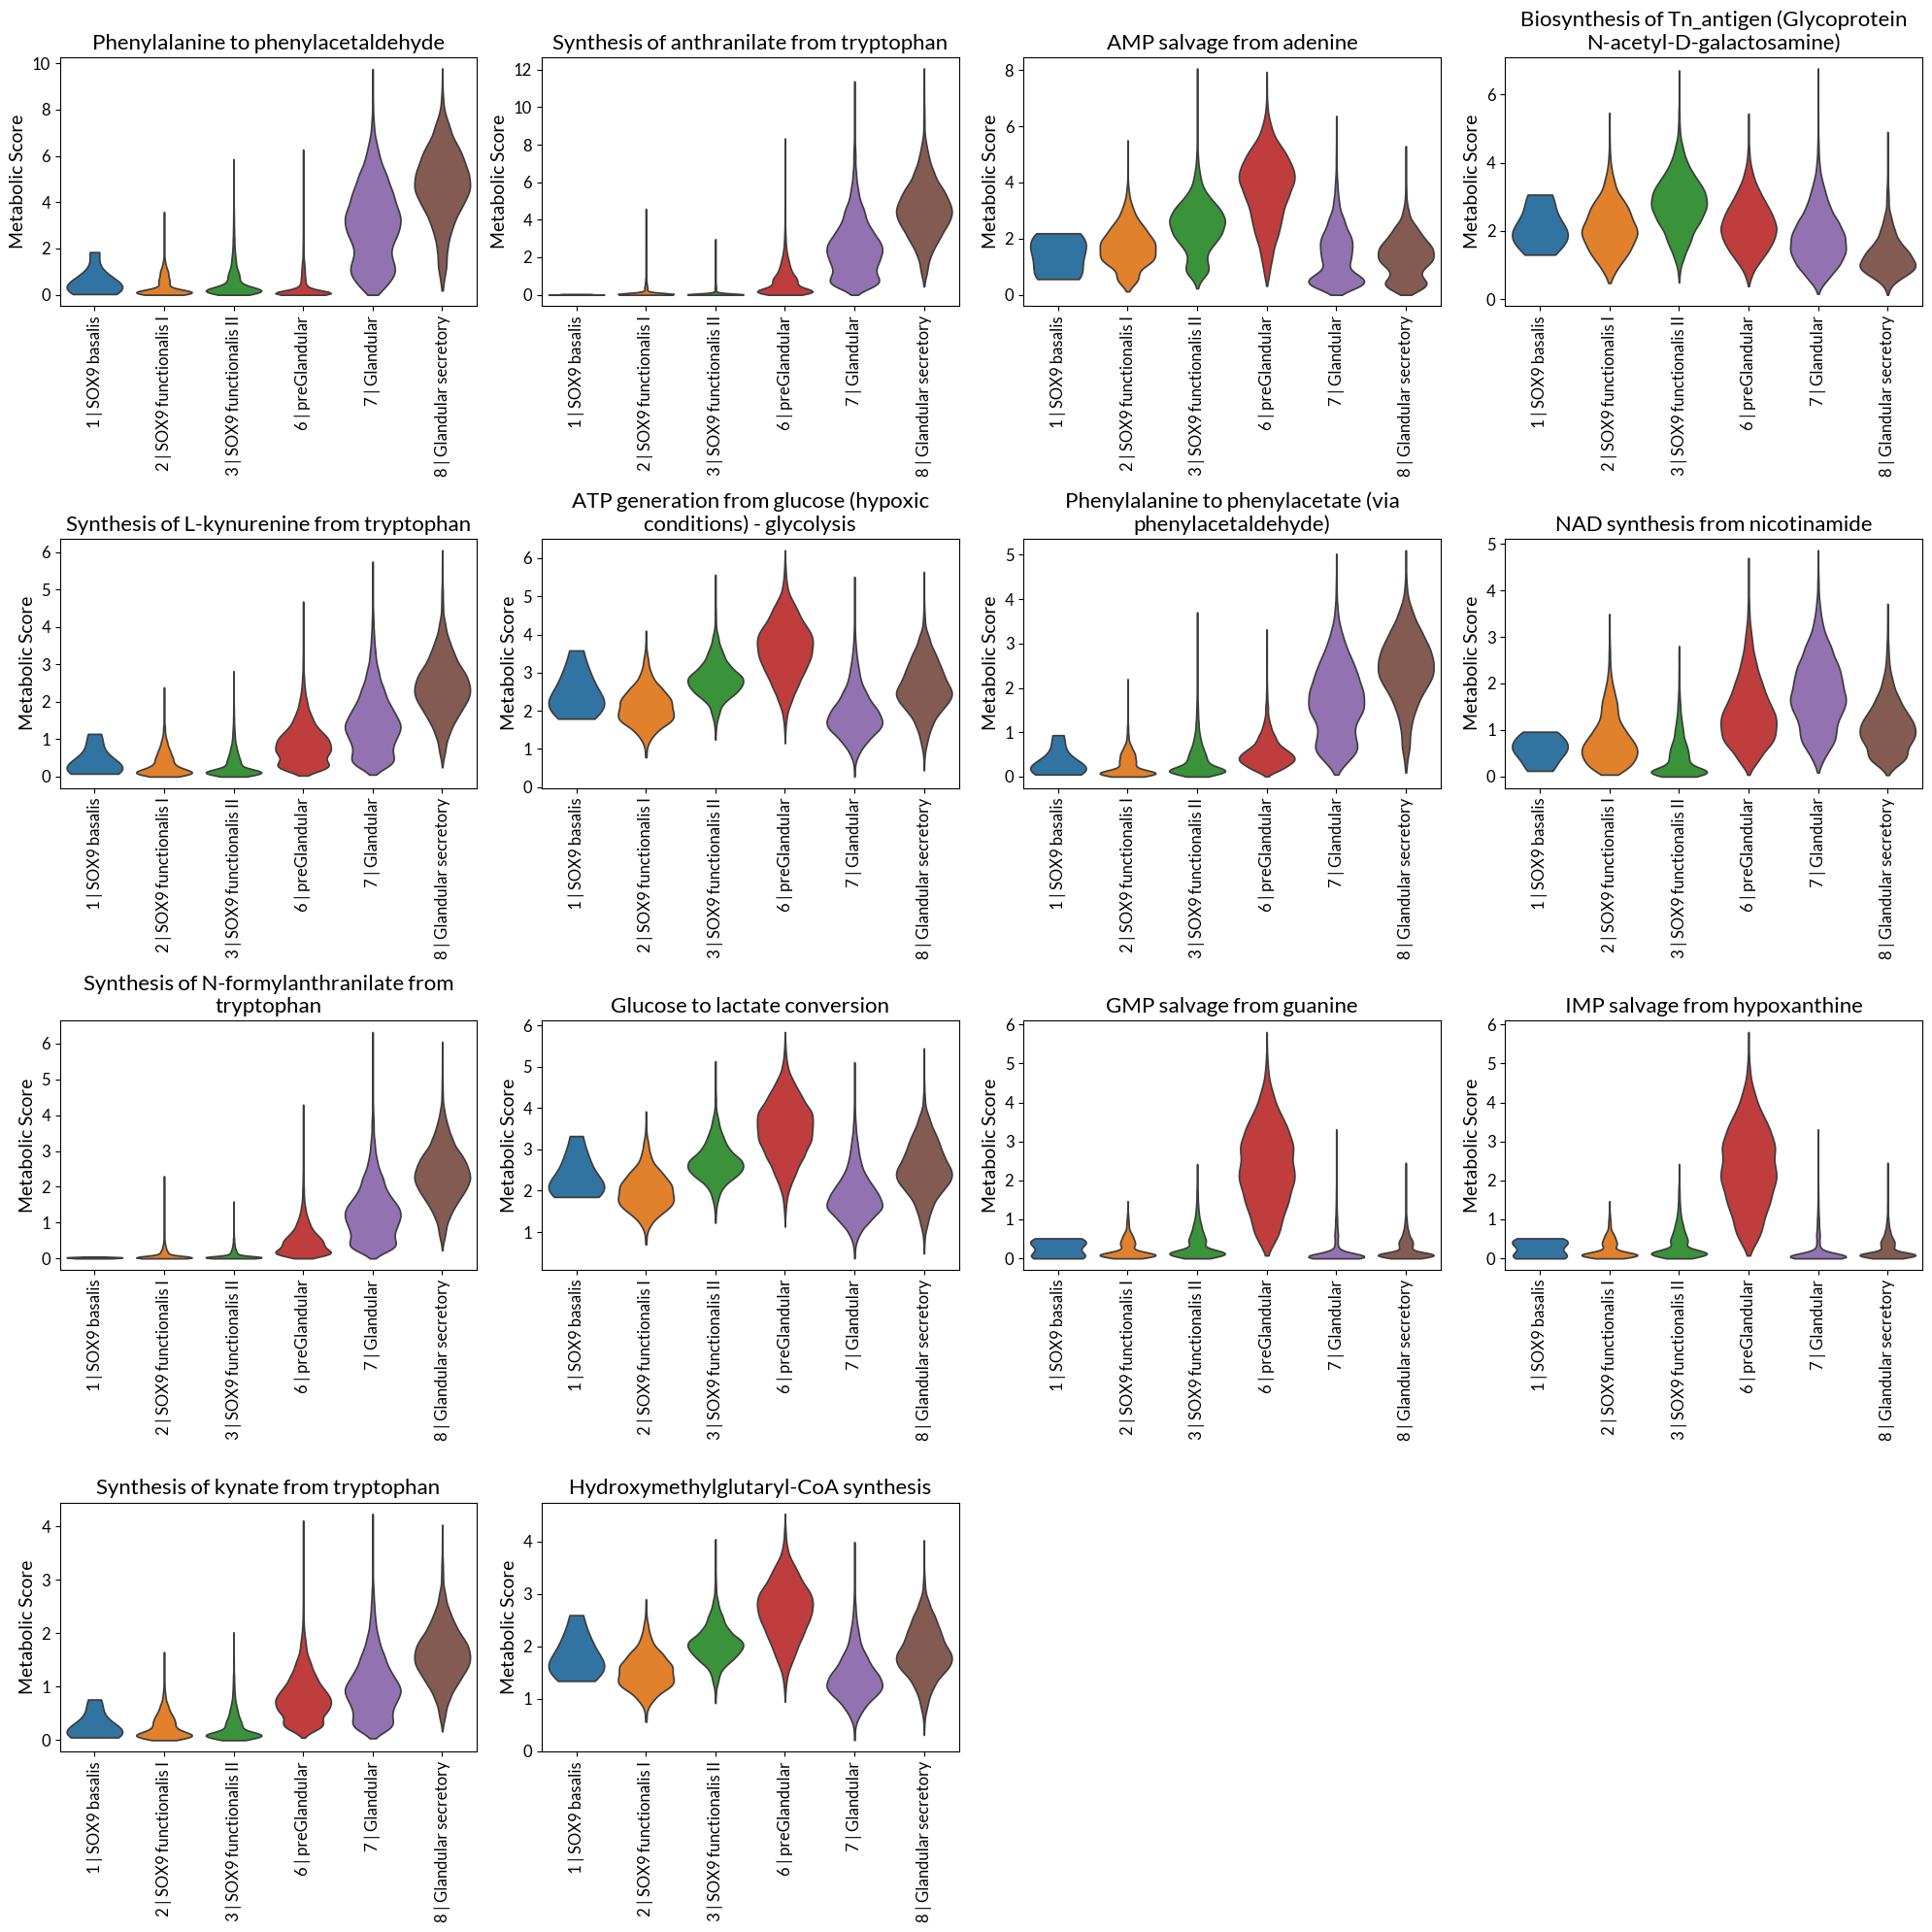

In [31]:
fig, axes = sccellfie.plotting.create_multi_violin_plots(mt_adata,
                                                         features=gam_tasks,
                                                         groupby='label_long',
                                                         n_cols=4,
                                                         order=cells,
                                                         stripplot=False,
                                                         fontsize=12,
                                                         wrapped_title_length=45,
                                                         w_pad=None,
                                                         ylabel='Metabolic Score',
                                                         save=f'{saveprefix}-GAM-Violin-Control.pdf',
                                                         )

## Export results

In [32]:
agg_adata = filter_donors(mt_adata_og, only_control=False)

In [33]:
agg = sccellfie.expression.aggregation.agg_expression_cells(agg_adata, groupby='E_celltype', agg_func='trimean')

In [34]:
agg = agg.loc[[' - '.join([c, ct]) for ct in cells for c in ['Control', 'Endometriosis']], :]

In [35]:
agg.to_csv(f'{sc.settings.figdir}/{saveprefix}-Agg-results.csv')

In [38]:
with open(f'{sc.settings.figdir}/{saveprefix}-GAM-tasks.json', 'w') as f:
    json.dump(gam_tasks, f)

## Marsilea heatmap

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import glasbey

import marsilea.plotter as mp
import marsilea as ma

In [40]:
sccellfie_db = sccellfie.datasets.database.load_sccellfie_database(organism='human')

In [41]:
tasks = gam_tasks
control_cells = [c for c in agg.index if 'Control -' in c]

In [42]:
control_df = agg.loc[control_cells, tasks]
control_df.index = [idx.split(' - ')[1] for idx in control_df.index]
control_df

,Phenylalanine to phenylacetaldehyde,Synthesis of anthranilate from tryptophan,AMP salvage from adenine,Biosynthesis of Tn_antigen (Glycoprotein N-acetyl-D-galactosamine),Synthesis of L-kynurenine from tryptophan,ATP generation from glucose (hypoxic conditions) - glycolysis,Phenylalanine to phenylacetate (via phenylacetaldehyde),NAD synthesis from nicotinamide,Synthesis of N-formylanthranilate from tryptophan,Glucose to lactate conversion,GMP salvage from guanine,IMP salvage from hypoxanthine,Synthesis of kynate from tryptophan,Hydroxymethylglutaryl-CoA synthesis
1 | SOX9 basalis,0.421346,0.006802,1.312725,2.036176,0.322585,2.347263,0.226495,0.593189,0.021662,2.237830,0.278457,0.278457,0.215057,1.738242
2 | SOX9 functionalis I,0.244327,0.032532,1.704076,2.045852,0.261255,2.089057,0.190833,0.715057,0.046374,1.969611,0.183207,0.183207,0.208241,1.507165
3 | SOX9 functionalis II,0.362304,0.021750,2.445419,2.800748,0.220046,2.809900,0.274940,0.326090,0.047614,2.664268,0.274183,0.274183,0.181310,2.033904
6 | preGlandular,0.147185,0.577094,3.853242,2.145387,0.827232,3.633128,0.502715,1.316344,0.435947,3.494902,2.317455,2.317455,0.765151,2.696159
7 | Glandular,2.994363,2.337398,1.277490,1.754736,1.361957,1.863711,1.666511,1.761603,1.208521,1.822167,0.084810,0.084810,0.942275,1.372566
8 | Glandular secretory,4.800221,4.502616,1.352345,1.205786,2.369770,2.593348,2.475707,1.030484,2.330312,2.520021,0.183862,0.183862,1.587399,1.871038


In [43]:
df_plot = sccellfie.preprocessing.min_max_normalization(control_df.T, axis=1)

In [44]:
cell_groups = {'Basal' : [ct_dict[c] for c in ['SOX9_basalis']],
               'Proliferative / Folicular' : [ct_dict[c] for c in ['SOX9_functionalis_I', 'SOX9_functionalis_II']],
               'Secretory / Luteal' : [ct_dict[c] for c in ['preGlandular', 'Glandular', 'Glandular_secretory']] #'Glandular_secretory_FGF7'
              }

cell_groups = {cell : phase for phase, cells in cell_groups.items() for cell in cells}

In [45]:
task_dict = sccellfie_db['task_info'].set_index('Task')['System'].to_dict()
task_dict = {k : v.capitalize() for k, v in task_dict.items()}
for k, v in task_dict.items():
    if v == 'Processing in the er':
        task_dict[k] = 'Processing in the ER'
    elif v == 'Processing in the golgi':
        task_dict[k] = 'Processing in the Golgi'

In [46]:
data = df_plot.values
cell_labels = np.asarray(list(df_plot.columns))
task_labels = np.asarray(list(df_plot.index))
cell_cat = np.asarray([cell_groups[cell] for cell in df_plot.columns])
task_cat = np.asarray([task_dict[task] for task in df_plot.index])

In [47]:
total_task_cat = sorted(set(task_dict.values()))
task_palette = glasbey.extend_palette('tab10', palette_size=len(total_task_cat))
task_colors = {t : task_palette[i] for i, t in enumerate(total_task_cat)}
cell_palette = ['#FFABA4', '#D8A3B7', '#EDAF5C']

In [55]:
cell_labels = [c.split(' | ')[1] for c in cell_labels]

In [56]:
plt.rc('legend',fontsize=28, title_fontsize=32)

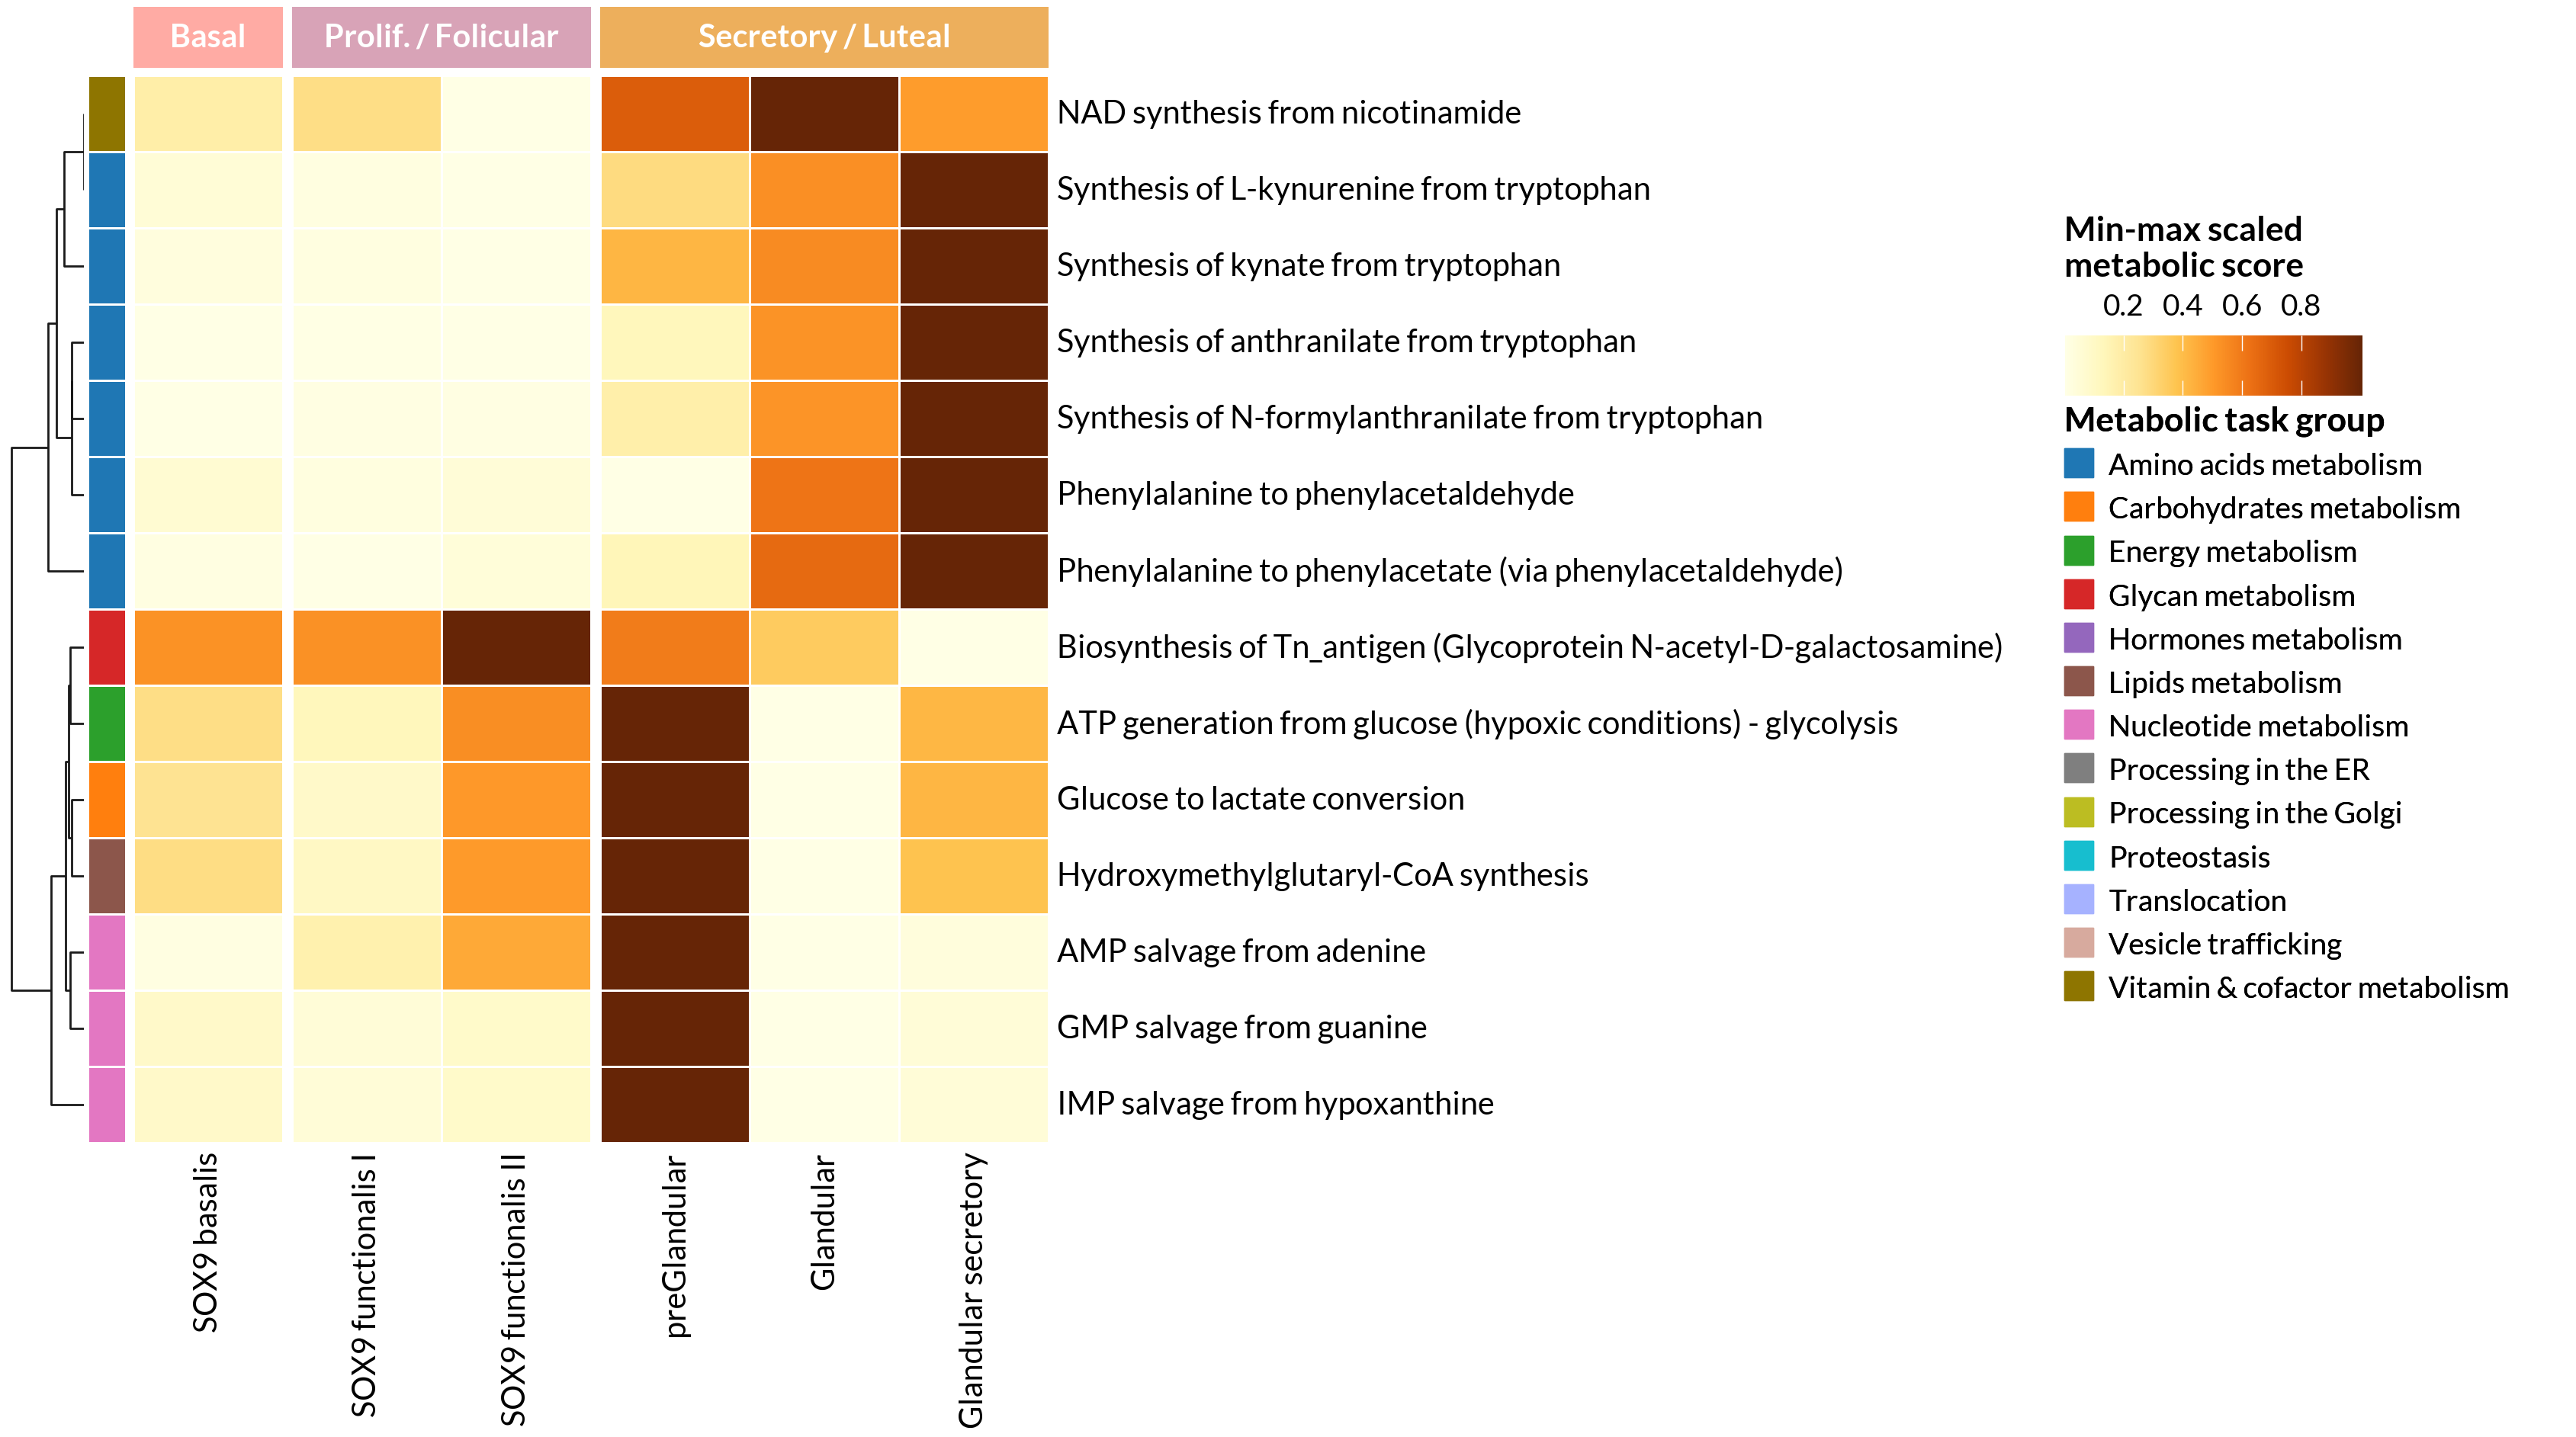

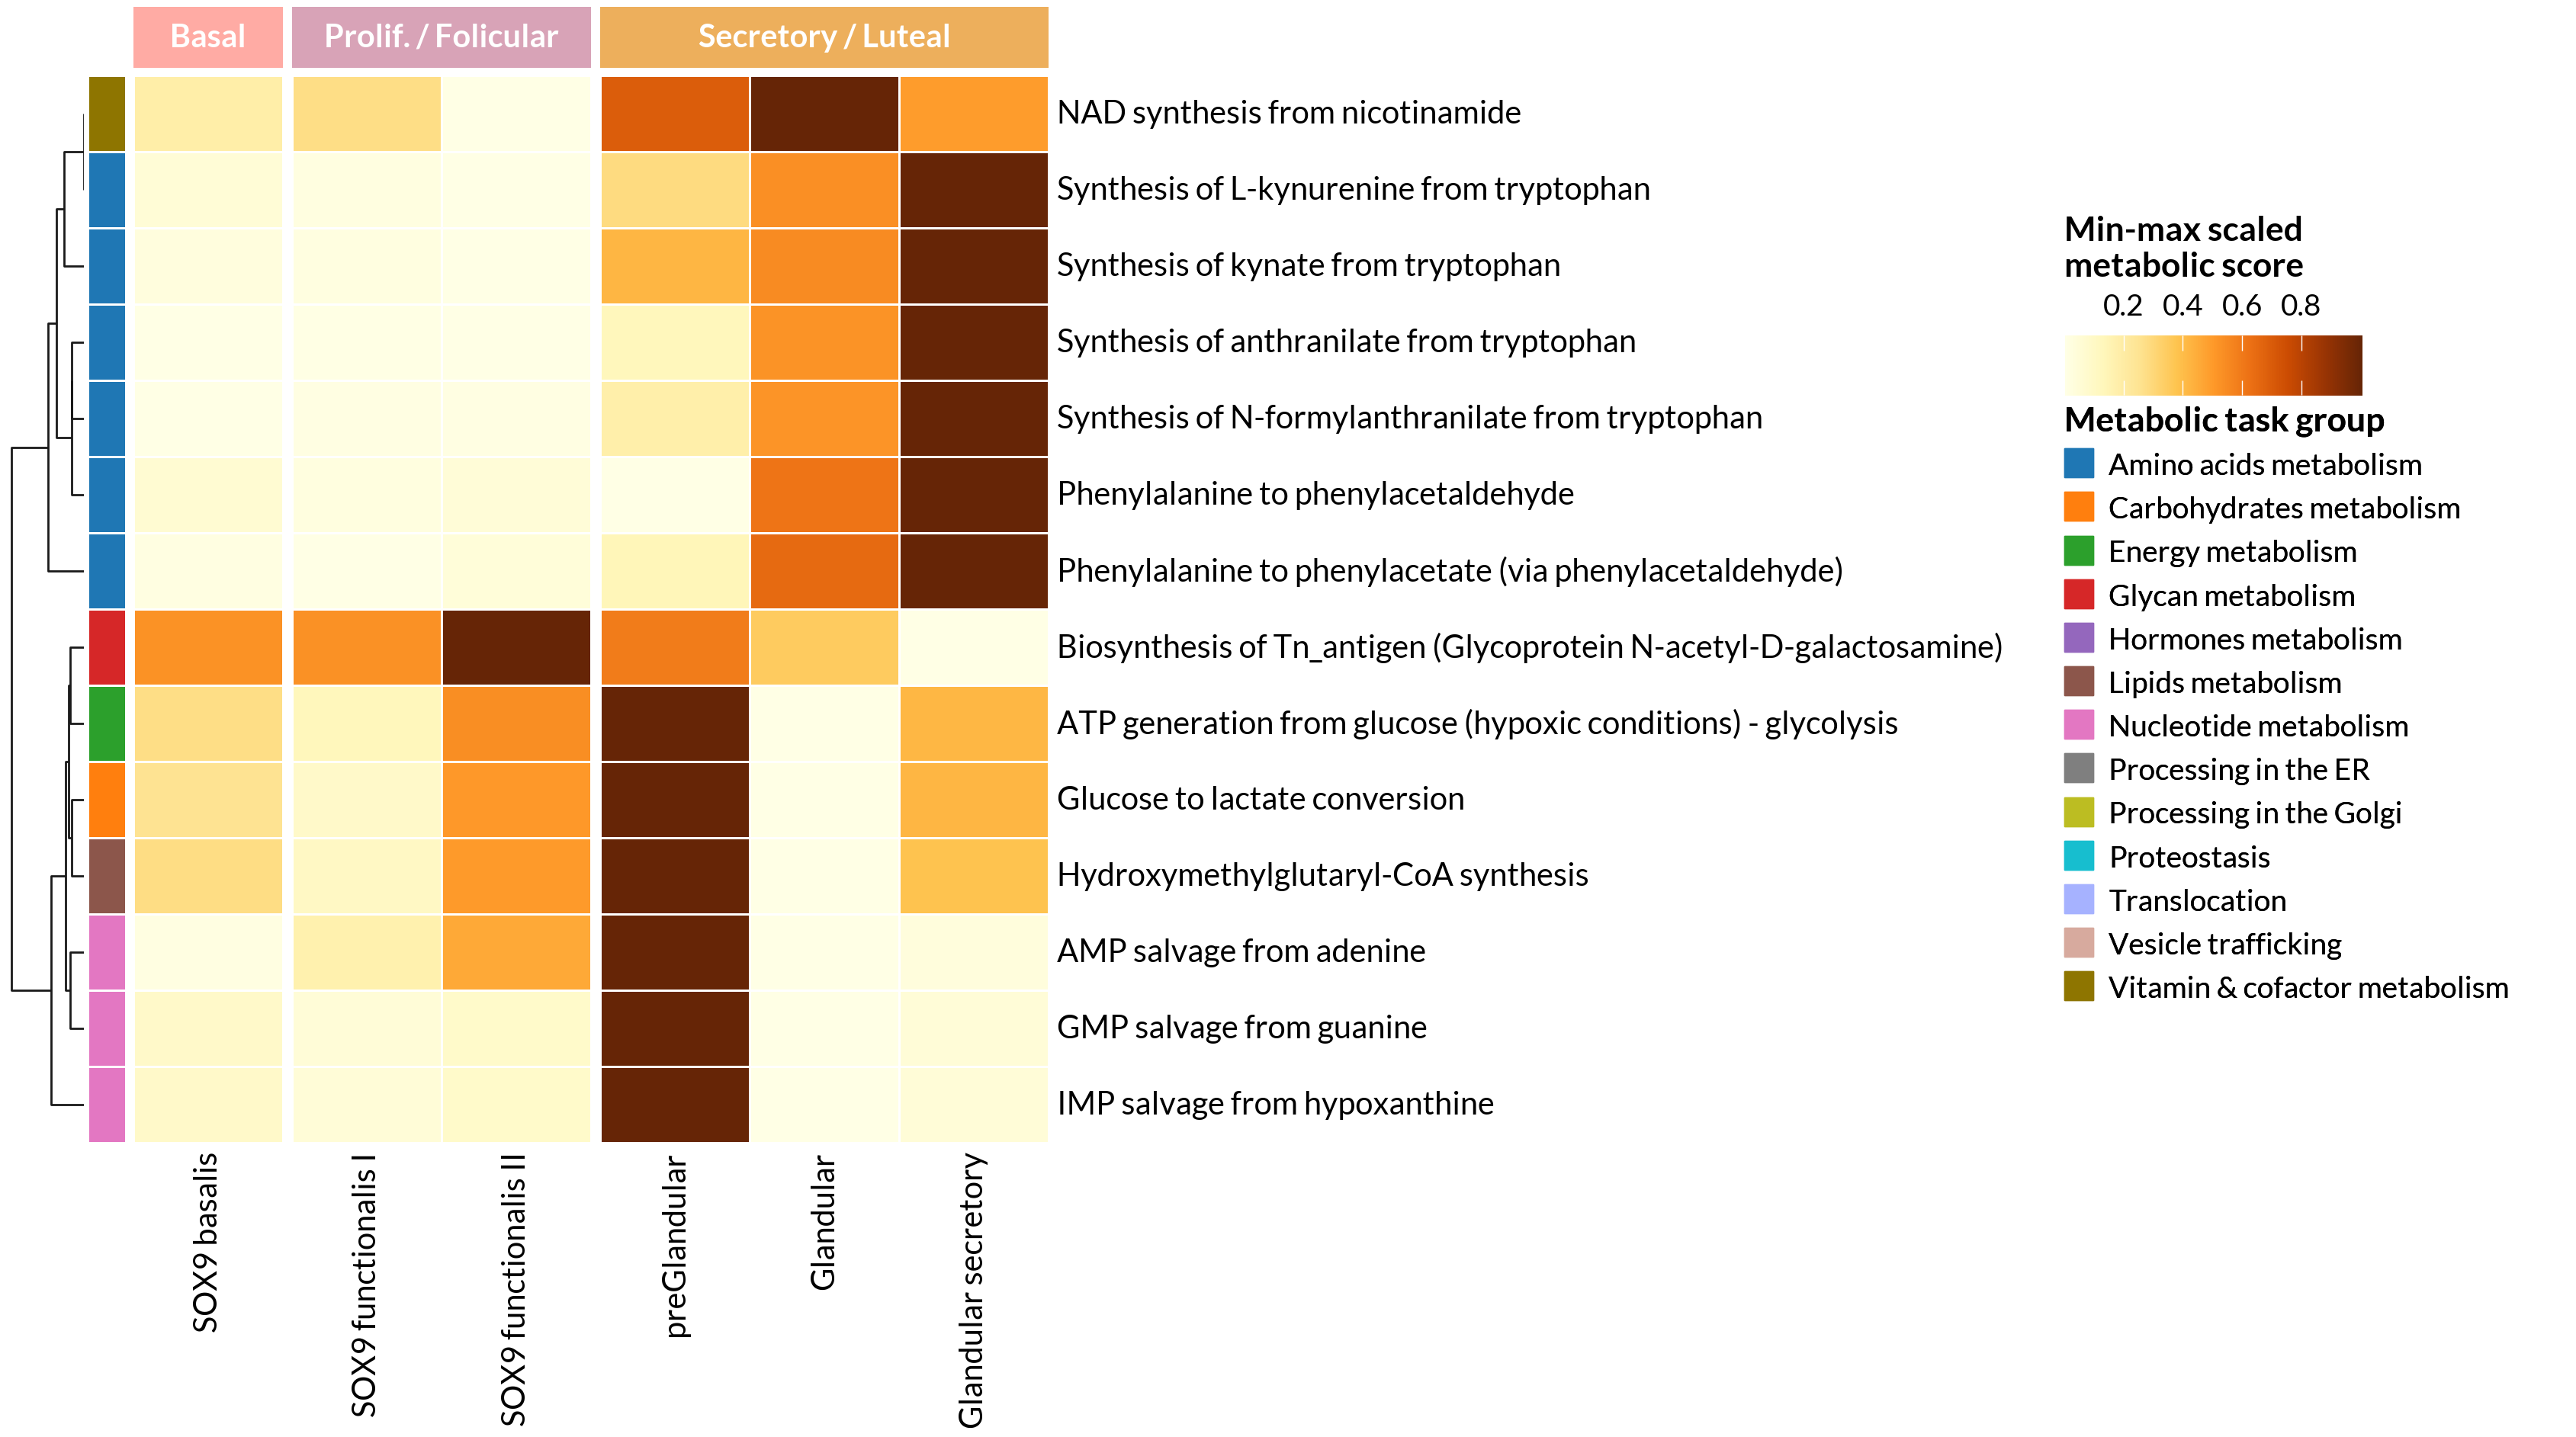

In [57]:
vlimit = np.max(np.abs(data))
linewidth = 2.
h = ma.Heatmap(data, linewidth=linewidth, vmin=0, vmax=1, height=1*len(gam_tasks), width=2*len(cells), cmap='YlOrBr',
               cbar_kws={'title' : 'Min-max scaled\nmetabolic score', 'orientation' : 'horizontal'}, 
              )

#h.add_top(mp.Colors(cell_cat, palette=cell_palette, label='', legend_kws={'title' : 'Cell type hroup'}), size=.5, pad=.1)
h.group_cols(cell_cat, order=['Basal', 'Proliferative / Folicular', 'Secretory / Luteal'], spacing=0.01)
h.add_top(mp.Chunk(['Basal', 'Prolif. / Folicular', 'Secretory / Luteal'], cell_palette, padding=30, fontsize=30, fontweight='bold', c='white'), pad=0.1)
h.add_left(mp.Colors(task_cat, palette=task_colors, label='', legend_kws={'title' : 'Metabolic task group'}, linewidth=linewidth, linecolor='white'), size=.5, pad=.1)
h.add_bottom(mp.Labels(cell_labels, fontsize=30, rotation=90, rotation_mode='anchor', ha='right', va='center'), pad=.1)
h.add_right(mp.Labels(task_labels, fontsize=30, rotation=0, rotation_mode='anchor', ha='left', va='center'), pad=.1)
#h.vsplit(labels=cell_labels, order=sorted(set(cell_labels)), spacing=0.001)
#h.hsplit(labels=task_cat, order=sorted(set(task_cat)), spacing=0.)
#h.add_dendrogram("top", method='ward', metric='euclidean', size=1, linewidth=1., add_base=False)
h.add_dendrogram("left", method='ward', metric='euclidean', size=1, linewidth=2., add_base=True, pad=0.05)
h.add_legends(stack_size=3, stack_by='col', align_legends='left')
h.render()
h.save(f'{sc.settings.figdir}/{saveprefix}-Heatmap.pdf', dpi=300)